### Imports

In [108]:
import matplotlib as mpl

import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['lines.markersize'] = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from numba import jit

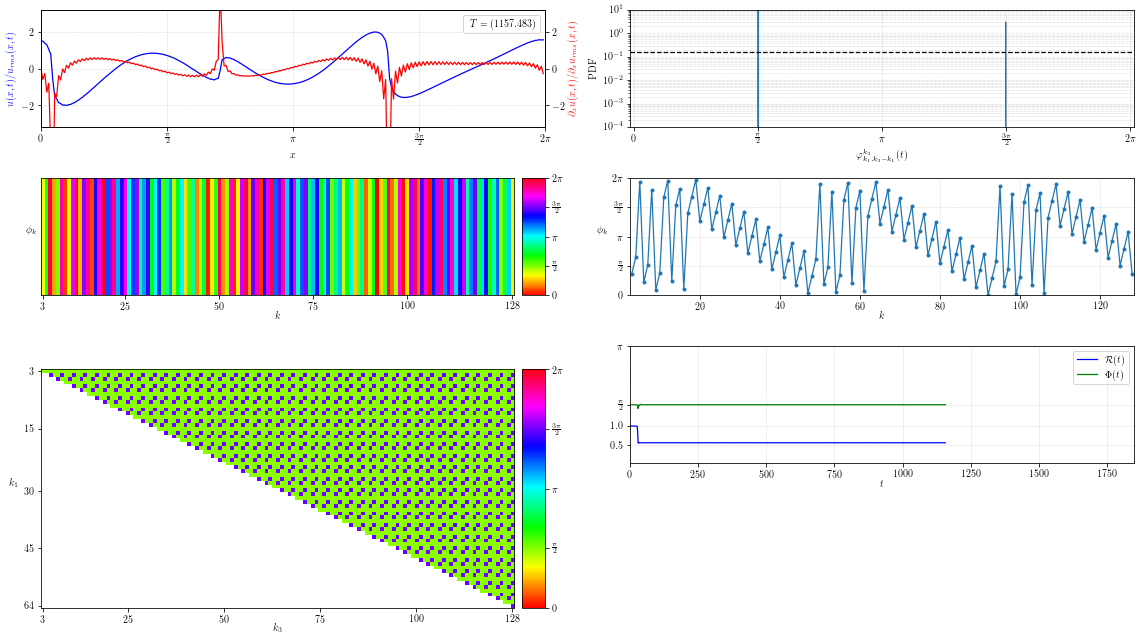

In [109]:
i = 2504
plot_snaps(i, x, u_urms[i, :], du_x_rms[i, :], time[i, 0], triads[:, :, i], kmin, kmax, phases[i, kmin:], R[0:i], Phi[0:i], time[0, 0], time[-1, 0], time[0:i, 0])

### Plot Snaps Def

In [90]:
def plot_snaps(i, x, u_urms, du_x_rms, time, triads, kmin, kmax, phases, R, Phi, t0, T, fullTime):
#     print("SNAP {}\n".format(i))

    ## CREATE FIGURE
    fig = plt.figure(figsize = (16, 9), tight_layout=True)
    gs  = GridSpec(4, 2)


    ## REAL SPACE
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x, u_urms, color = 'blue')
    ax7 = ax1.twinx()
    ax7.plot(x, du_x_rms, color = 'red')
    ax7.set_ylim(-3.2, 3.2)
    ax7.set_ylabel(r"$\partial_x u(x, t) / \partial_x u_{rms}(x, t)$", color = 'red')
    ax1.set_xlim(0, 2*np.pi)
    ax1.set_ylim(-3.2, 3.2)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$u(x, t) / u_{rms}(x, t)$', color = 'blue')
    ax1.set_xticks([0.0, np.pi/2.0, np.pi, 1.5*np.pi, 2*np.pi]);
    ax1.set_xticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2 \pi$"]);
    leg1 = mpl.patches.Rectangle((0, 0), 0, 0, alpha = 0.0)
    ax1.legend([leg1], [r"$T=({:04.3f})$".format(time)], handlelength = -0.5, fancybox = True, prop = {'size': 10})
    ax1.grid(which = 'both', linestyle=':', linewidth='0.5', axis = 'both')

    ## PDF
    ax2 = fig.add_subplot(gs[0, 1])
    hist, bins  = np.histogram(np.extract(triads != -10, triads).flatten(), range = (0.0 - 0.5, 2.0 * np.pi + 0.5), bins = 100, density = True);
    bin_centers = (bins[1:] + bins[:-1]) * 0.5
    ax2.plot(bin_centers, hist)
    ax2.set_xlim(-0.05, 2 * np.pi+0.05);
    ax2.set_ylim(1e-4, 10)
    ax2.axhline(y = 1 / (2 * np.pi), xmin = 0, xmax = 1., ls = '--', c = 'black');
    ax2.set_xticks([0.0, np.pi/2.0, np.pi, 1.5*np.pi, 2*np.pi]);
    ax2.set_xticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2 \pi$"]);
    ax2.set_xlabel(r'$\varphi_{k_1, k_3 - k_1}^{k_3}(t)$');
    ax2.set_ylabel(r'PDF');
    ax2.set_yscale('log');
    ax2.grid(which = 'both', linestyle=':', linewidth='0.5', axis = 'both');

    ## PHASES - BARPLOT
    ax3  = fig.add_subplot(gs[1, 0])
    div3 = make_axes_locatable(ax3)
    cax3 = div3.append_axes('right', size = '5%', pad = 0.1)
    ax3.bar(x = np.arange(kmin, kmax + 1), height = 1, width = 1, align = 'center', color = m.to_rgba(np.mod(phases, 2.0 * np.pi)), linewidth =  0)
    ax3.set_xlim(kmin - 0.5, kmax + 0.5)
    ax3.set_yticks([ ])
    ax3.set_yticklabels([ ])
    ax3.set_xticks([kmin, int((kmax - kmin)/5), int(2 * (kmax - kmin)/5), int(3* (kmax - kmin)/5), int(4 * (kmax - kmin)/5), kmax])
    ax3.set_ylim([0, 1])
    ax3.set_xlabel(r'$k$', labelpad = 0)
    ax3.set_ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    cbar3 = mpl.colorbar.ColorbarBase(cax3, cmap = my_mhsv, norm = norm)
    cbar3.set_ticks([0.0, np.pi/2.0, np.pi, 3.0*np.pi/2.0, 2.0*np.pi])
    cbar3.set_ticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])

    ## PHASES - vs k
    ax5  = fig.add_subplot(gs[1, 1])
    ax5.plot(np.arange(kmin, kmax + 1), np.mod(phases, 2.0 * np.pi), '.-')
    ax5.set_xlim(kmin - 0.5, kmax + 0.5)
    ax5.set_ylim([0, 2 * np.pi])
    ax5.set_xlabel(r'$k$', labelpad = 0)
    ax5.set_ylabel(r'$\phi_k$', rotation = 0, labelpad = 10)
    ax5.set_yticks([0, np.pi / 2.0, np.pi, 3.0 * np.pi / 2.0, 2.0 * np.pi])
    ax5.set_yticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    ax5.grid(which = 'both', linestyle=':', linewidth='0.5', axis = 'both');


    ## PHASES - vs k
    ax6  = fig.add_subplot(gs[2, 1])
    ax6.plot(fullTime, R, color = 'blue')
    ax6.plot(fullTime, Phi, color = 'green')
    ax6.set_xlim(t0, T)
    ax6.set_ylim([0.0, np.pi])
    ax6.set_xlabel(r'$t$', labelpad = 0)
    ax6.set_yticks([0.5, 1.0, np.pi / 2.0, np.pi])
    ax6.set_yticklabels([r"$0.5$", r"$1.0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    ax6.legend([r"$\mathcal{R}(t)$", r"$\Phi(t)$"])
    ax6.grid(which = 'both', linestyle=':', linewidth='0.5', axis = 'both');


    ## TRIADS
    ax4 = fig.add_subplot(gs[2:, 0])
    im  = ax4.imshow(np.transpose(triads), cmap = my_m, norm = my_norm)
    kMax = kmax - kmin # Adjusted indices in triads matrix
    kMin = kmin - kmin # Adjusted indices in triads matrix
    ax4.set_xticks([kmin, int((kMax - kMin)/5), int(2 * (kMax - kMin)/5), int(3* (kMax - kMin)/5), int(4 * (kMax - kMin)/5), kMax])
    ax4.set_xticklabels([kmin, int((kmax - kmin)/5), int(2 * (kmax - kmin)/5), int(3* (kmax - kmin)/5), int(4 * (kmax - kmin)/5), kmax])
    ax4.set_yticks([kMin, int((kMax / 2 - kMin)/4), int(2 * (kMax / 2 - kMin)/4), int(3* (kMax / 2 - kMin)/4),  int((kmax)/ 2 - kmin)])
    ax4.set_yticklabels([kmin, int((kmax / 2 - kmin)/4), int(2 * (kmax / 2 - kmin)/4), int(3* (kmax / 2 - kmin)/4),  int(kmax / 2)])
    ax4.set_xlabel(r'$k_3$', labelpad = 0)
    ax4.set_ylabel(r'$k_1$',  rotation = 0, labelpad = 10)
    ax4.set_xlim(left = kmin - 0.5)
    ax4.set_ylim(bottom = int((kmax)/ 2 - kmin) + 0.5)
    div4  = make_axes_locatable(ax4)
    cax4  = div4.append_axes('right', size = '5%', pad = 0.1)
    cbar4 = plt.colorbar(im, cax = cax4, orientation='vertical')
    cbar4.set_ticks([ 0.0, np.pi/2.0, np.pi, 3.0*np.pi/2.0, 2.0*np.pi])
    cbar4.set_ticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    
    plt.savefig("Triad_SNAPS_{:05d}.png".format(i), format='png', dpi = 400) 
    
    plt.show()

#     plt.savefig("Triad_SNAPS_{:05d}.png".format(i), format='png', dpi = 400)  
#     plt.savefig("Triad_SNAPS_{:05d}.png".format(i), format='pdf') 
#     plt.close()


### Other function Defs

In [4]:
## Create the triads from the phases
@jit(nopython = True)
def compute_triads(phases, kmin, kmax):
    print("\n...Computing Triads...\n")

    ## Variables
    numTriads  = 0;
    k3_range   = int(kmax - kmin + 1)
    k1_range   = int((kmax - kmin + 1) / 2)
    time_steps = phases.shape[0]

    ## Create memory space
    triadphase = -10 * np.ones((k3_range, k1_range, time_steps))
    triads     = -10 * np.ones((k3_range, k1_range, time_steps))
    phaseOrder = np.complex(0.0, 0.0) * np.ones((time_steps))
    R          = np.zeros((time_steps))
    Phi        = np.zeros((time_steps))

    ## Compute the triads
    for k in range(kmin, kmax + 1):
        for k1 in range(kmin, int(k/2) + 1):
            triadphase[k - kmin, k1 - kmin, :] = phases[:, k1] + phases[:, k - k1] - phases[:, k]
            triads[k - kmin, k1 - kmin, :]     = np.mod(triadphase[k - kmin, k1 - kmin, :], 2*np.pi)

            phaseOrder[:] += np.exp(np.complex(0.0, 1.0)*triads[k - kmin, k1 - kmin, :])
            numTriads += 1

    # Compute Phase-Order params
    R[:]   = np.absolute(phaseOrder[:] / numTriads)
    Phi[:] = np.angle(phaseOrder[:] / numTriads)

    return triads, R, Phi

In [5]:
## Real Space Data
def compute_realspace(amps, phases, N):
    print("\n...Creating Real Space Soln...\n")

    # Create full set of amps and phases
    amps_full   = np.append(amps[0, :], np.flipud(amps[0, 1:-1]))
    phases_full = np.concatenate((phases[:, :], -np.fliplr(phases[:, 1:-1])), axis = 1)

    # Construct modes and realspace soln
    u_z = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
    u   = np.real(np.fft.ifft(u_z, axis = 1))

    # Compute normalized realspace soln
    u_rms  = np.sqrt(np.mean(u[:, :]**2, axis = 1))
    u_urms = np.array([u[i, :] / u_rms[i] for i in range(u.shape[0])])

    x = np.arange(0, 2*np.pi, 2*np.pi/N)

    return u, u_urms, x, u_z

In [6]:
def compute_gradient(u_z, kmin, kmax):
    print("\nCreating Gradient\n")
    k            = np.concatenate((np.zeros((kmin)), np.arange(kmin, kmax + 1), -np.flip(np.arange(kmin, kmax)), np.zeros((kmin - 1))))
    grad_u_z     = np.complex(0.0, 1.0) * k * u_z
    du_x         = np.real(np.fft.ifft(grad_u_z, axis = 1))
    du_x_rms_tmp = np.sqrt(np.mean(du_x ** 2, axis = 1))
    du_x_rms     = np.array([du_x[i, :] / du_x_rms_tmp[i] for i in range(u_z.shape[0])])

    return du_x, du_x_rms

### Read In Data

In [114]:
k0 = 2
alpha = 1.5
beta  = 0.0
iters = 400000
N     = 64

filename = "/LCE_Runtime_Data_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[ALIGNED]_ITERS[{}]".format(N, k0, alpha, beta, iters)
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Output/LCE"
# output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/TriadDynamics" + filename
HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')


In [115]:
list(HDFfileData.keys())

['Amps', 'LCE', 'Phases', 'Time']

In [116]:
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:, :]
amps   = HDFfileData['Amps'][:, :]


ntsteps = phases.shape[0];
num_osc = phases.shape[1];
N       = 2 * num_osc - 1 - 1;
kmin    = k0 + 1;
kmax    = amps.shape[1] - 1
k0      = kmin - 1;
if 'Triads' in list(HDFfileData.keys()):
    R      = HDFfileData['PhaseOrderR'][:, :]
    Phi    = HDFfileData['PhaseOrderPhi'][:, :]
    triad  = HDFfileData['Triads']
    # Reshape triads
    tdims     = triad.attrs['Triad_Dims']
    triads    = np.array(np.reshape(triad, np.append(triad.shape[0], tdims[0, :])))

    triads_exist = 1
else:
    ## Call triad function
    triads, R, Phi = compute_triads(phases, kmin, kmax)
    triads_exist = 0


...Computing Triads...



### Colourmaps

In [117]:
colours = [[1, 1, 1], [1, 1, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 0, 1], [1, 0, 0], [1, 0.25, 0], [1, 1, 1]]   #located @ 0, pi/2, pi, 3pi/2 and 2pi
my_m    = mpl.colors.LinearSegmentedColormap.from_list('my_map', cm.hsv(np.arange(255)), N = kmax)                            # set N to inertial range
my_m.set_under('1.0')
my_norm = mpl.colors.Normalize(vmin = 0, vmax = 2*np.pi)

# Phases Colourmap
myhsv   = cm.hsv(np.arange(255))
norm    = mpl.colors.Normalize(vmin = 0.0, vmax = 2.0*np.pi)
my_mhsv = mpl.colors.LinearSegmentedColormap.from_list('my_map', myhsv, N = kmax) # set N to inertial range
m       = cm.ScalarMappable( norm = norm, cmap = my_mhsv)                         # map the values to rgba tuple

In [118]:
## Call realspace function
u, u_urms, x, u_z = compute_realspace(amps, phases, N)

## Compute Real Space velocity Gradient
du_x, du_x_rms = compute_gradient(u_z, k0, kmax)


...Creating Real Space Soln...


Creating Gradient



In [119]:
2**14

16384

In [120]:
for k in range(kmin, kmax + 1):
        for k1 in range(kmin, int(k/2) + 1):
            print((k1, k - k1, k), end = '')
        print()




(3, 3, 6)
(3, 4, 7)
(3, 5, 8)(4, 4, 8)
(3, 6, 9)(4, 5, 9)
(3, 7, 10)(4, 6, 10)(5, 5, 10)
(3, 8, 11)(4, 7, 11)(5, 6, 11)
(3, 9, 12)(4, 8, 12)(5, 7, 12)(6, 6, 12)
(3, 10, 13)(4, 9, 13)(5, 8, 13)(6, 7, 13)
(3, 11, 14)(4, 10, 14)(5, 9, 14)(6, 8, 14)(7, 7, 14)
(3, 12, 15)(4, 11, 15)(5, 10, 15)(6, 9, 15)(7, 8, 15)
(3, 13, 16)(4, 12, 16)(5, 11, 16)(6, 10, 16)(7, 9, 16)(8, 8, 16)
(3, 14, 17)(4, 13, 17)(5, 12, 17)(6, 11, 17)(7, 10, 17)(8, 9, 17)
(3, 15, 18)(4, 14, 18)(5, 13, 18)(6, 12, 18)(7, 11, 18)(8, 10, 18)(9, 9, 18)
(3, 16, 19)(4, 15, 19)(5, 14, 19)(6, 13, 19)(7, 12, 19)(8, 11, 19)(9, 10, 19)
(3, 17, 20)(4, 16, 20)(5, 15, 20)(6, 14, 20)(7, 13, 20)(8, 12, 20)(9, 11, 20)(10, 10, 20)
(3, 18, 21)(4, 17, 21)(5, 16, 21)(6, 15, 21)(7, 14, 21)(8, 13, 21)(9, 12, 21)(10, 11, 21)
(3, 19, 22)(4, 18, 22)(5, 17, 22)(6, 16, 22)(7, 15, 22)(8, 14, 22)(9, 13, 22)(10, 12, 22)(11, 11, 22)
(3, 20, 23)(4, 19, 23)(5, 18, 23)(6, 17, 23)(7, 16, 23)(8, 15, 23)(9, 14, 23)(10, 13, 23)(11, 12, 23)
(3, 21, 24)(4, 20